# Hello World ODBC
This notebook walks through basic code examples of integrating xGT with MySQL, pandas, networkx, and jgraph

## trovares_connector
trovares_connector with ODBC can be installed with: `python -m pip install 'trovares_connector[odbc]'`

## Connect
Connect to xGT and the MySQL database

In [15]:
from trovares_connector import ODBCConnector, SQLODBCDriver
import xgt
import pyodbc

xgt_server = xgt.Connection()
connection_string = 'Driver={MariaDB};Server=127.0.0.1;Port=3306;Database=test;Uid=test;Pwd=foo;'
odbc_driver = SQLODBCDriver(connection_string)
c = ODBCConnector(xgt_server, odbc_driver)
pyodbc_driver = pyodbc.connect(connection_string)
cursor = pyodbc_driver.cursor()

## Create a graph in MySQL

In [16]:
cursor.execute("DROP TABLE IF EXISTS Knows")
cursor.execute("DROP TABLE IF EXISTS Person")
pyodbc_driver.commit()
names = ["Nicole", "Nathan", "Bishop", "Ashley", "Joe"]
cursor.execute('CREATE TABLE Person (id INT, name varchar(255))')                 
cursor.execute('CREATE TABLE Knows (Person1 INT, Person2 INT)')
cursor.execute(f'INSERT INTO Person VALUES (0, \'{names[0]}\')')                
for i in range(0, len(names) - 1):                                      
    cursor.execute(f'INSERT INTO Person VALUES ({i + 1}, \'{names[i + 1]}\')')     
    cursor.execute(f'INSERT INTO Knows VALUES ({i}, {i + 1})') 
cursor.execute('INSERT INTO Knows VALUES (2, 0)')              
pyodbc_driver.commit()                                         
                                                               

## Transfer data to xGT
Transfers data associated with edge, `Knows`, including the associated vertices

In [17]:
c.transfer_to_xgt(tables=[('Person', ('id',)), ('Knows', ('Person', 'Person', 'Person1', 'Person2'))])

Transferring: [############################################################] 10/10 in 0:00:00.0s (516.3/s, eta: 0:00:00.0s)     


## Cypher
Retrieve python query results

In [18]:
query = "match(a)-->()-->()-->(a) return a.name"

job = xgt_server.run_job(query)
print("xGT found the following relationship triangle: " + ', '.join(str(row[0]) for row in job.get_data()))

xGT found the following relationship triangle: Bishop, Nathan, Nicole


## Save results to disk

In [10]:
query = "match(a)-->()-->()-->(a) return a.name into results"

xgt_server.run_job(query)
xgt_server.get_frame("results").save("results.csv")
xgt_server.drop_frame("results")

True

## Pandas DataFrames
Convert results into a pandas dataframe

In [11]:
job.get_data_pandas()

a_name
0  Bishop
1  Nathan
2  Nicole

## NetworkX
Getting data into networkx

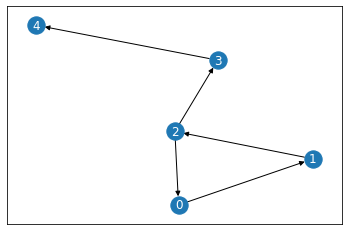

In [12]:
import networkx as nx

edge_data = [tuple(x) for x in xgt_server.get_frame("Knows").get_data()]
vertex_data = xgt_server.get_frame("Person").get_data()

dg = nx.DiGraph()

dg.add_edges_from(edge_data)
nx.set_node_attributes(dg, {row[0]:row[1] for row in vertex_data}, name="name")

nx.draw_networkx(dg, font_color='white')

In [13]:
dg.nodes(data=True)

NodeDataView({0: {'name': 'Nicole'}, 1: {'name': 'Nathan'}, 2: {'name': 'Bishop'}, 3: {'name': 'Ashley'}, 4: {'name': 'Joe'}})

In [14]:
nx.degree(dg)

DiDegreeView({0: 2, 1: 2, 2: 3, 3: 2, 4: 1})

## jgraph
Visualizing the graph with jgraph

In [15]:
import jgraph

data =  xgt_server.run_job("match(a)-->(b) return a.id, b.id").get_data()
data = [tuple(x) for x in data]
jgraph.draw(data)